<a href="https://colab.research.google.com/github/sanjana1976/Facial-Detection/blob/master/dibiasing_detection_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet
import comet_ml

# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "mfq8WTlM0gHW140OWD2A1vsC4"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.7/743.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 61.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.3/682.3 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 5.7 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
import os
import random
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    cudnn.benchmark = True
else:
  raise ValueError("GPU is not available. Change Colab runtime.")

In [3]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

# Create a simple check to avoid re-downloading
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)

# Instantiate a TrainingDatasetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

100%|██████████| 1.18G/1.18G [01:11<00:00, 17.6MB/s]

Opening /root/.cache/mitdeeplearning/train_face.h5
Loading data into memory...


In [4]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [5]:
B, C, H, W = images.shape


In [6]:
### Define the CNN model ###

n_filters = 12  # base number of convolutional filters
in_channels = images.shape[1]

def make_standard_classifier(n_outputs):
  """Create a standard CNN classifier."""

  # Start by first defining a convolutional block
  class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

  # now use the block to define the classifier
  model = nn.Sequential(
      ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
      ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
      ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
      ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
      nn.Flatten(),
      nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512, n_outputs),
  )

  return model.to(device)

# call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

In [7]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if "experiment" in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

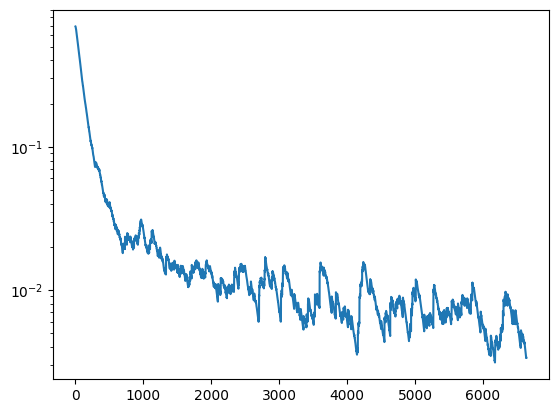

100%|██████████| 3434/3434 [00:32<00:00, 104.24it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : heavy_goose_9335
COMET INFO:     url                   : https://www.comet.com/sanjana-jk/6s191-lab2-part2-cnn/d0343f274ee14c27a232261fa1c5f9b5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (2.43892316120764e-07, 0.6903269290924072)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=105Py7vPOqU5w8Rs94prbzWupQwl5O4fJ
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO: 

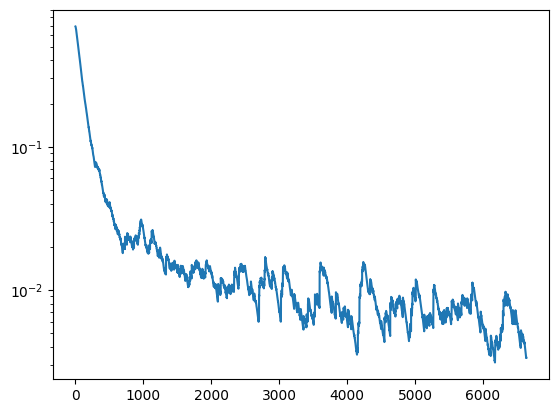

In [8]:
### Train the standard CNN ###
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size=32,
    num_epochs=2,  # keep small to run faster
    learning_rate=5e-4,
)

experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params["learning_rate"]
)  # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)  # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale="semilogy")
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()  # clear if it exists

# set the model to train mode
standard_classifier.train()


def standard_train_step(x, y):
    x = torch.from_numpy(x).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # clear the gradients
    optimizer.zero_grad()

    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = loss_fn(logits, y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss


# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
    for idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"])
        loss = standard_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        experiment.log_metric("loss", loss_value, step=step)
        step += 1

experiment.end()

In [9]:
### Evaluation of standard CNN ###

# set the model to eval mode
standard_classifier.eval()

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
batch_x = torch.from_numpy(batch_x).float().to(device)
batch_y = torch.from_numpy(batch_y).float().to(device)

with torch.inference_mode():
    y_pred_logits = standard_classifier(batch_x)
    y_pred_standard = torch.round(torch.sigmoid(y_pred_logits))
    acc_standard = torch.mean((batch_y == y_pred_standard).float())

print(
    "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(
        acc_standard.item()
    )
)

Standard CNN accuracy on (potentially biased) training set: 0.9990


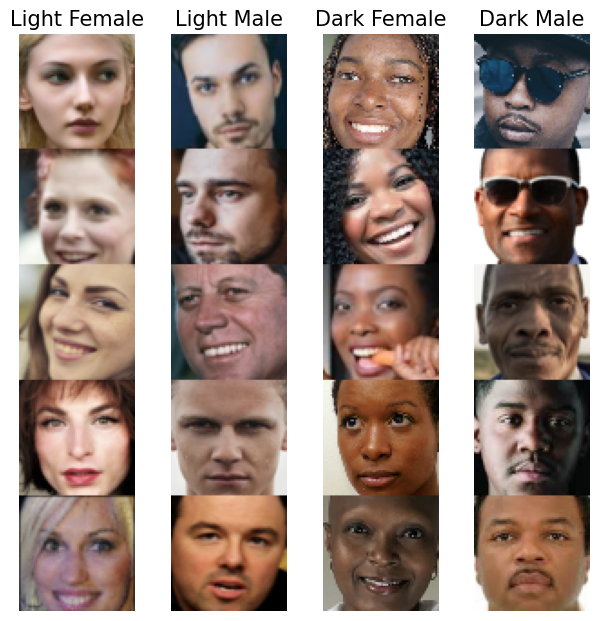

In [10]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]

fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Text(0.5, 1.0, 'Standard classifier predictions')

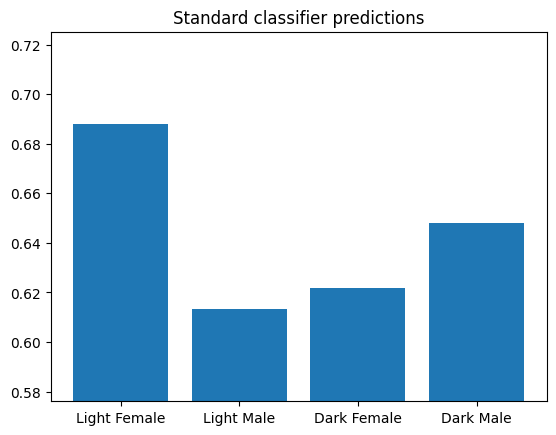

In [11]:
### Evaluate the standard CNN on the test data ###

standard_classifier_probs_list = []  # store each demographic's probabilities

with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = standard_classifier(x)  # [B, 1]
        probs = torch.sigmoid(logits)  # [B, 1]
        probs = torch.squeeze(probs, dim=-1)  # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())

standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)


# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)  # shape [D]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")

In [12]:
### Defining the VAE loss function ###
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    # KL Divergence latent loss
    latent_loss = -0.5 * torch.sum(
        1 + 2 * logsigma - mu.pow(2) - torch.exp(2 * logsigma),
        dim=1  # sum over latent dimensions
    )
    latent_loss = torch.mean(latent_loss)  # average over batch

    # Reconstruction loss (mean absolute pixel-wise error)
    reconstruction_loss = torch.mean(torch.abs(x - x_recon))

    # Total VAE loss
    vae_loss = kl_weight * latent_loss + reconstruction_loss

    return vae_loss


In [17]:
# Correct reparameterization (logsigma = log σ)
def sampling(z_mean, z_logsigma):
    eps = torch.randn_like(z_mean)
    z = z_mean + torch.exp(z_logsigma) * eps
    return z

In [34]:
import torch
import torch.nn.functional as F

def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    """
    Computes the total loss for DB-VAE.

    Args:
        x: original input images
        x_pred: reconstructed images from decoder
        y: true labels (face=1, non-face=0), shape [B] or [B,1]
        y_logit: predicted logits for face classification, shape [B,1] or [B]
        mu: mean of latent distribution (Q(z|X))
        logsigma: log of standard deviation of latent distribution (Q(z|X))

    Returns:
        total_loss: mean total DB-VAE loss
        classification_loss: mean classification loss
    """
    # Ensure y is [B,1] float tensor
    y = y.float()
    if y.dim() == 1:
        y = y.view(-1, 1)

    # Ensure y_logit is [B,1]
    if y_logit.dim() == 1:
        y_logit = y_logit.view(-1, 1)

    # VAE loss (reconstruction + KL divergence)
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

    # Classification loss (binary cross-entropy with logits)
    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y)

    # Face indicator: 1 if face, 0 if not face
    face_indicator = (y == 1.0).float()

    # Total DB-VAE loss: only add VAE loss for face images
    total_loss = torch.mean(classification_loss + face_indicator * vae_loss)

    return total_loss, classification_loss.mean()


In [35]:

### Define the decoder portion of the DB-VAE ###

n_filters = 12  # base number of convolutional filters, same as standard CNN
latent_dim = 100  # number of latent variables


def make_face_decoder_network(latent_dim=100, n_filters=12):
    """
    Function builds a face-decoder network.

    Args:
        latent_dim (int): the dimension of the latent representation
        n_filters (int): base number of convolutional filters

    Returns:
        decoder_model (nn.Module): the decoder network
    """

    class FaceDecoder(nn.Module):
        def __init__(self, latent_dim, n_filters):
            super(FaceDecoder, self).__init__()

            self.latent_dim = latent_dim
            self.n_filters = n_filters

            # Linear (fully connected) layer to project from latent space
            # to a 4 x 4 feature map with (6*n_filters) channels
            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 4 * 4 * 6 * n_filters), nn.ReLU()
            )

            # Convolutional upsampling (inverse of an encoder)
            self.deconv = nn.Sequential(
                # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
                nn.ConvTranspose2d(
                    in_channels=6 * n_filters,
                    out_channels=4 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 4n_filters, 8, 8] -> [B, 2n_filters, 16, 16]
                nn.ConvTranspose2d(
                    in_channels=4 * n_filters,
                    out_channels=2 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
                nn.ConvTranspose2d(
                    in_channels=2 * n_filters,
                    out_channels=n_filters,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, n_filters, 32, 32] -> [B, 3, 64, 64]
                nn.ConvTranspose2d(
                    in_channels=n_filters,
                    out_channels=3,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
            )

        def forward(self, z):
            """
            Forward pass of the decoder.

            Args:
                z (Tensor): Latent codes of shape [batch_size, latent_dim].

            Returns:
                Tensor of shape [batch_size, 3, 64, 64], representing
                the reconstructed images.
            """
            x = self.linear(z)  # [B, 4*4*6*n_filters]
            x = x.view(-1, 6 * self.n_filters, 4, 4)  # [B, 6n_filters, 4, 4]

            # Upsample through transposed convolutions
            x = self.deconv(x)  # [B, 3, 64, 64]
            return x

    return FaceDecoder(latent_dim, n_filters)

In [36]:
class DB_VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder outputs: [ y_logit | z_mean (latent_dim) | z_logsigma (latent_dim) ]
        self.encoder = make_standard_classifier(n_outputs=2 * latent_dim + 1)
        # Make decoder; pass latent_dim explicitly to be safe
        self.decoder = make_face_decoder_network(latent_dim=latent_dim)

    def encode(self, x):
        encoder_output = self.encoder(x)
        y_logit = encoder_output[:, 0].unsqueeze(-1)
        z_mean = encoder_output[:, 1 : self.latent_dim + 1]
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]
        return y_logit, z_mean, z_logsigma

    # VAE reparameterization
    def reparameterize(self, z_mean, z_logsigma):
        z = sampling(z_mean, z_logsigma)   # uses the corrected sampling()
        return z

    # Decode latent -> reconstruction
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    # Full forward pass
    def forward(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = self.reparameterize(z_mean, z_logsigma)
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

# Instantiate (and move to GPU)
dbvae = DB_VAE(latent_dim).to(device)


In [37]:
# Function to return the means for an input image batch

def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []

    # If images is NumPy, convert once outside the loop
    images_t = torch.from_numpy(images).float()

    with torch.inference_mode():
        for start in range(0, len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end]
            batch = batch.to(device).permute(0, 3, 1, 2)
            # Forward pass on this chunk only
            _, z_mean, _, _ = dbvae(batch)
            all_z_mean.append(z_mean.cpu())

    # Concatenate all partial z_mean
    z_mean_full = torch.cat(all_z_mean, dim=0)  # shape [N, latent_dim]
    mu = z_mean_full.numpy()  # convert to NumPy if needed
    return mu

In [38]:
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    # 1. Run the input batch and get latent means (mu)
    mu = get_latent_mu(images, dbvae)

    # Initialize probability array
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64)

    # 2. Loop over each latent variable dimension
    for i in range(latent_dim):
        latent_distribution = mu[:, i]

        # Histogram estimate of density
        hist_density, bin_edges = np.histogram(
            latent_distribution, density=True, bins=bins
        )

        # Adjust edges for digitize
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")

        # 3. Digitize: find which bin each data point falls into
        bin_idx = np.digitize(latent_distribution, bin_edges)

        # 4. Smooth density
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density /= np.sum(hist_smoothed_density)

        # 5. Invert: rare bins → high probability
        p = 1.0 / (hist_smoothed_density[bin_idx - 1])

        # Normalize
        p = p / np.sum(p)

        # 6. Keep the *maximum* probability across latent dimensions
        training_sample_p = np.maximum(training_sample_p, p)

    # 7. Final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p


In [39]:
### Training the DB-VAE ###

# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=2,  # DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)
def debiasing_train_step(x, y):
    optimizer.zero_grad()

    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    # Call DB-VAE loss
    loss, class_loss = debiasing_loss_function(
        x, x_recon, y, y_logit, z_mean, z_logsigma
    )

    loss.backward()
    optimizer.step()

    return loss


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : characteristic_photometry_2219
COMET INFO:     url                   : https://www.comet.com/sanjana-jk/6s191-lab2-part2-dbvae/64a3ff748537461fbc54d5efae9b80d3
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=105Py7vPOqU5w8Rs94prbzWupQwl5O4fJ
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     latent_dim    : 100
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET IN

Starting epoch 2/2
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

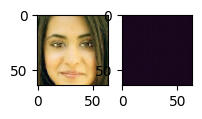

 15%|█▍        | 499/3434 [00:04<00:26, 111.82it/s]

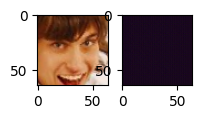

 29%|██▉       | 996/3434 [00:09<00:27, 88.67it/s]

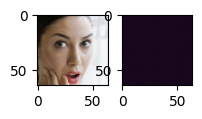

 43%|████▎     | 1489/3434 [00:14<00:18, 107.20it/s]

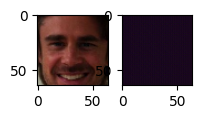

 58%|█████▊    | 1997/3434 [00:19<00:12, 111.64it/s]

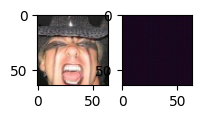

 73%|███████▎  | 2492/3434 [00:24<00:08, 109.54it/s]

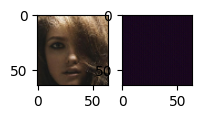

 87%|████████▋ | 2991/3434 [00:29<00:04, 107.24it/s]

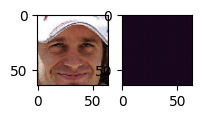

100%|██████████| 3434/3434 [00:33<00:00, 103.30it/s]


In [42]:
# Training loop
all_faces = loader.get_all_train_faces()

step = 0
for i in range(params["num_epochs"]):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, params["num_epochs"]))

    # Recompute debiasing sampling probabilities (faces only!)
    p_faces = get_training_sample_probabilities(all_faces, dbvae)

    # Iterate batches
    for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Load batch: p_pos ensures faces are sampled with debiasing
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        # Optimize
        loss = debiasing_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
        experiment.log_metric("loss", loss_value, step=step)

        # Visualize progress
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae, backend="pt")

        step += 1

experiment.end()


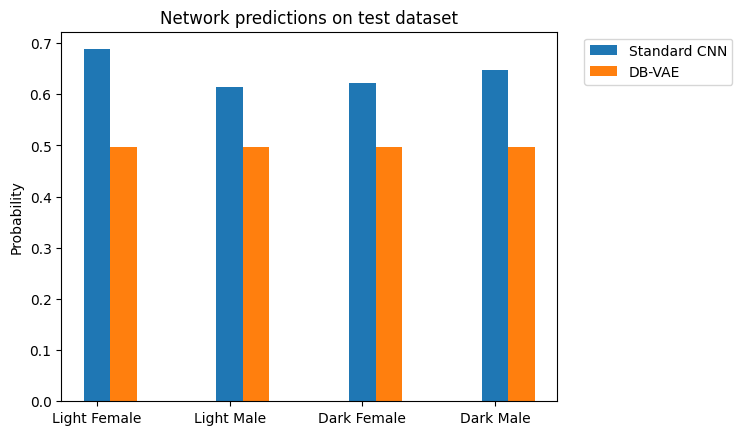

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [44]:
dbvae.to(device)
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to(device)

    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)

    dbvae_logits_list.append(logit.detach().cpu().numpy())

dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()

xx = np.arange(len(keys))

std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)

plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")

plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()